# <font color='blue'>Deep Learning II</font>

# Redes Neurais Recorrentes LSTM - Long Short-Term Memory 

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

# Prevendo Séries Temporais com Stacked LSTMs 

Finalmente, vejamos um dos maiores benefícios das LSTMs, o fato de que elas podem ser treinadas com sucesso quando empilhadas em arquiteturas de redes profundas. As redes LSTM podem ser empilhadas em Keras da mesma maneira que outros tipos de camada podem ser empilhadas. Uma adição é que a camada LSTM anterior a cada camada LSTM subsequente, deve retornar a sequência. Isso pode ser feito configurando o parâmetro return_sequences = True na camada 1. 

<a id = 'etapa1'></a>
## Etapa 1: Conjunto de dados

Previsão do número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares - AIH. Os dados tem registros dos anos de 2010 a 2020.

Será fornecido 1 dataset com 2 colunas, data e número de Óbitos.

Usaremos conjuntos de dados que mostram o número de óbitos de pacientes acima de 50 anos nas internações hospitalares – AIH em Minas Gerais.

Os dados foram baixados do site do Datasus, módulo SIHSUS, tipo de arquivo RD- AIH Reduzida, anos de 2010 a 2020, UF MG, todos os meses:

http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1&acao=25

Foi realizado o download de 129 arquivos, com 5.231.829 registros utilizados para preparar um arquivo csv com o agrupamento das internações das pessoas acima de 50 anos que vieram a óbito, perfazendo um total de 3.896 registros diários, 556 registros por semana (excluindo-se a primeira e a última), com data, número e valor total das internações, dados desde 2010.

<a id='etapa2'></a>
## Etapa 2: Importar as Bibliotecas

In [1]:
import tensorflow as tf
tf.__version__

'1.10.0'

In [2]:
import keras as k
k.__version__

Using TensorFlow backend.


'2.2.5'

In [34]:
# Imports
import math
import numpy
import pandas
import os
import io
import requests


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import load_model

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [4]:
# Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [5]:
# Define o PATH onde estão os dados
save_path = "./save"

# Random seed 
numpy.random.seed(7)

look_back = 2

In [6]:
# Carrega os dados
dataframediario = pandas.read_csv("./data/AIH.csv", usecols = [0, 1], engine = 'python')
dataframediario['Data'] = pandas.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows
dataframediario.reset_index(drop=True)

datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

In [7]:
# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

In [8]:
# Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. Podemos normalizar facilmente o conjunto de dados usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

In [9]:
# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [10]:
dataset.shape

(417, 1)

In [11]:
train.shape

(279, 1)

In [12]:
valid.shape

(138, 1)

In [13]:
test.shape

(139, 1)

In [14]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [15]:
# Cria o modelo LSTM
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True, return_sequences = True))
model.add(LSTM(4, batch_input_shape = (batch_size, look_back, 1), stateful = True))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
for i in range(200):
    model.fit(trainX, trainY, epochs = 1, batch_size = batch_size, verbose = 2, shuffle = False)
    model.reset_states()

Epoch 1/1
 - 7s - loss: 0.0156
Epoch 1/1
 - 4s - loss: 0.0122
Epoch 1/1
 - 4s - loss: 0.0116
Epoch 1/1
 - 5s - loss: 0.0112
Epoch 1/1
 - 5s - loss: 0.0110
Epoch 1/1
 - 5s - loss: 0.0109
Epoch 1/1
 - 5s - loss: 0.0108
Epoch 1/1
 - 5s - loss: 0.0107
Epoch 1/1
 - 5s - loss: 0.0107
Epoch 1/1
 - 5s - loss: 0.0106
Epoch 1/1
 - 5s - loss: 0.0106
Epoch 1/1
 - 5s - loss: 0.0105
Epoch 1/1
 - 5s - loss: 0.0105
Epoch 1/1
 - 5s - loss: 0.0104
Epoch 1/1
 - 5s - loss: 0.0104
Epoch 1/1
 - 5s - loss: 0.0104
Epoch 1/1
 - 5s - loss: 0.0103
Epoch 1/1
 - 5s - loss: 0.0103
Epoch 1/1
 - 5s - loss: 0.0103
Epoch 1/1
 - 5s - loss: 0.0102
Epoch 1/1
 - 5s - loss: 0.0102
Epoch 1/1
 - 5s - loss: 0.0101
Epoch 1/1
 - 5s - loss: 0.0101
Epoch 1/1
 - 5s - loss: 0.0101
Epoch 1/1
 - 5s - loss: 0.0100
Epoch 1/1
 - 5s - loss: 0.0100
Epoch 1/1
 - 5s - loss: 0.0099
Epoch 1/1
 - 5s - loss: 0.0098
Epoch 1/1
 - 5s - loss: 0.0098
Epoch 1/1
 - 5s - loss: 0.0097
Epoch 1/1
 - 5s - loss: 0.0097
Epoch 1/1
 - 5s - loss: 0.0096
Epoch 1/

In [16]:
# Salvando a rede inteira no formato HDF5 (salvando todos os componentes da rede, incluindo os pesos)
model.save(os.path.join(save_path,"RNN02_AIH_LSTM_Stacked.h5"))

## Agora recarregamos o modelo para realizamos uma previsão.

In [17]:
# Carrega os dados
dataframediario = pandas.read_csv("./data/AIH.csv", usecols = [0, 1], engine = 'python')
dataframediario['Data'] = pandas.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows
dataframediario.reset_index(drop=True)

datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))

In [18]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_AIH_LSTM_Stacked.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 2, 4)                 96        
_________________________________________________________________
lstm_2 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Previsões
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)

In [20]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])

In [21]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 41.7801 RMSE
Score em Validação: 73.1018 RMSE


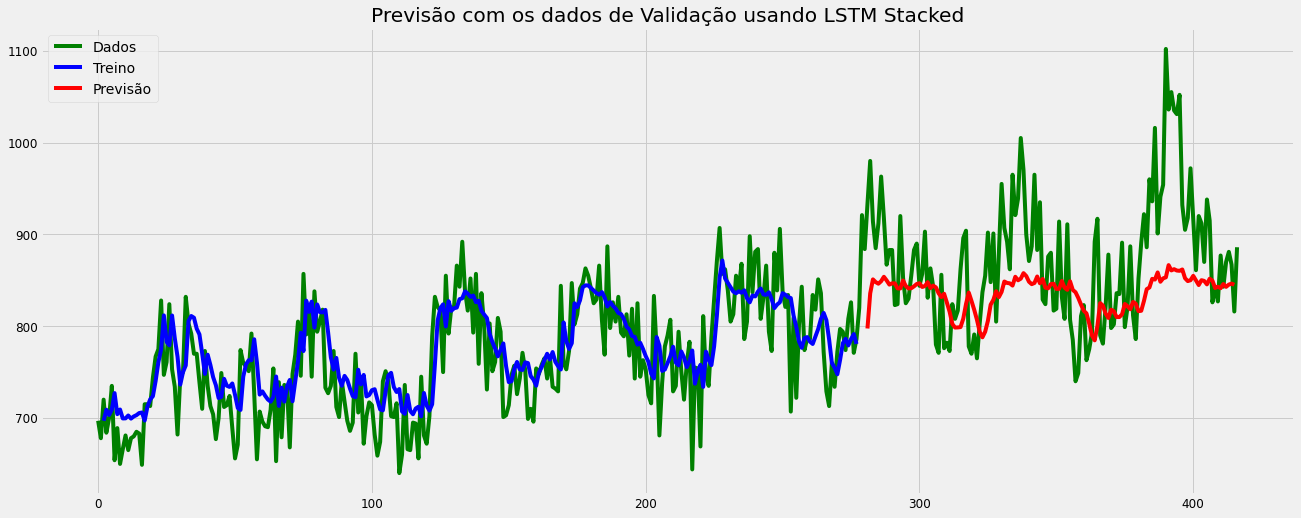

In [22]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação usando LSTM Stacked") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados', color = 'green')
plt.plot(trainPredictPlot, color = 'blue', label = 'Treino')
plt.plot(validPredictPlot, color = 'red', label = 'Previsão')
plt.legend(loc = 'upper left') 
plt.show()

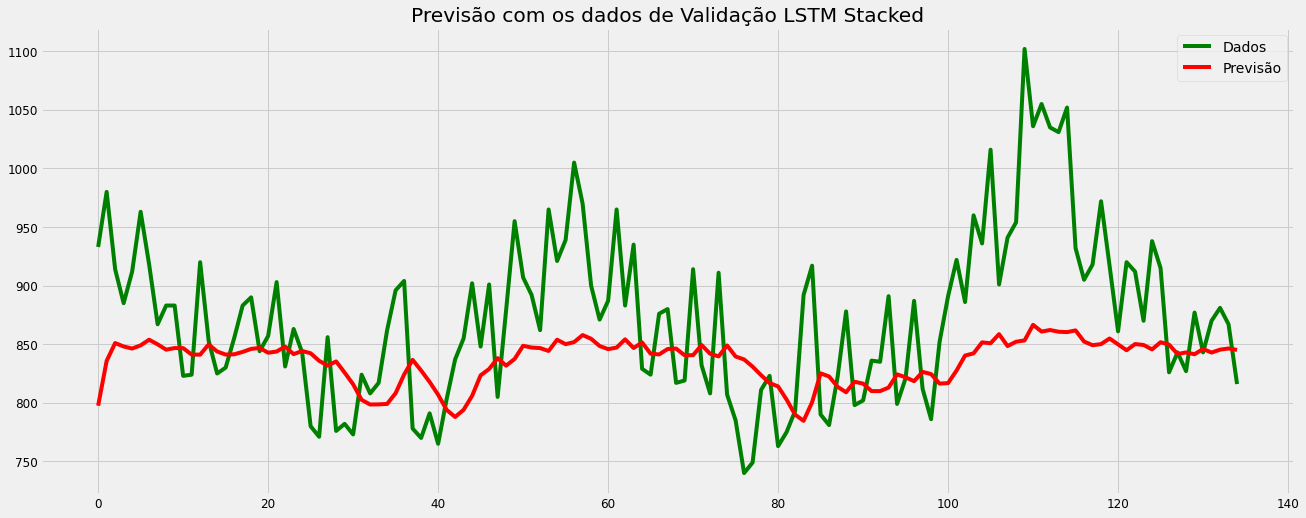

In [23]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação LSTM Stacked") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

## Vamos fazer o Forecasting para 24 meses de horizonte de previsão. 

In [24]:
# Carrega os dados
dataframediario = pandas.read_csv("./data/AIH.csv", usecols = [0, 1], engine = 'python')
dataframediario['Data'] = pandas.to_datetime(dataframediario.Data, format = '%d/%m/%Y')
dataframediario = dataframediario.set_index('Data')
# Reamostrando os dados para frequência semanal - Usando o valor médio do número de óbitos de pacientes – AIH
dataframesemanal = dataframediario['QT_INTER'].resample('W').sum()
dataframe = dataframesemanal.to_frame()
dataframe.drop(dataframe.head(1).index,inplace=True) # drop first 1 rows
dataframe.drop(dataframe.tail(1).index,inplace=True) # drop last 1 rows
dataframediario.reset_index(drop=True)

datasetfull = dataframe.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
# Time steps
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
validX = numpy.reshape(validX, (validX.shape[0], validX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [25]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_AIH_LSTM_Stacked.h5"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 2, 4)                 96        
_________________________________________________________________
lstm_2 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Previsões com dados de Teste
#model.reset_states()
trainPredict = model.predict(trainX, batch_size = batch_size)
model.reset_states()
validPredict = model.predict(validX, batch_size = batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size = batch_size)

In [27]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scalerTeste.inverse_transform(testPredict)
testY = scalerTeste.inverse_transform([testY])

In [28]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 41.7801 RMSE
Score em Validação: 73.1018 RMSE
Score em Teste: 72.6560 RMSE


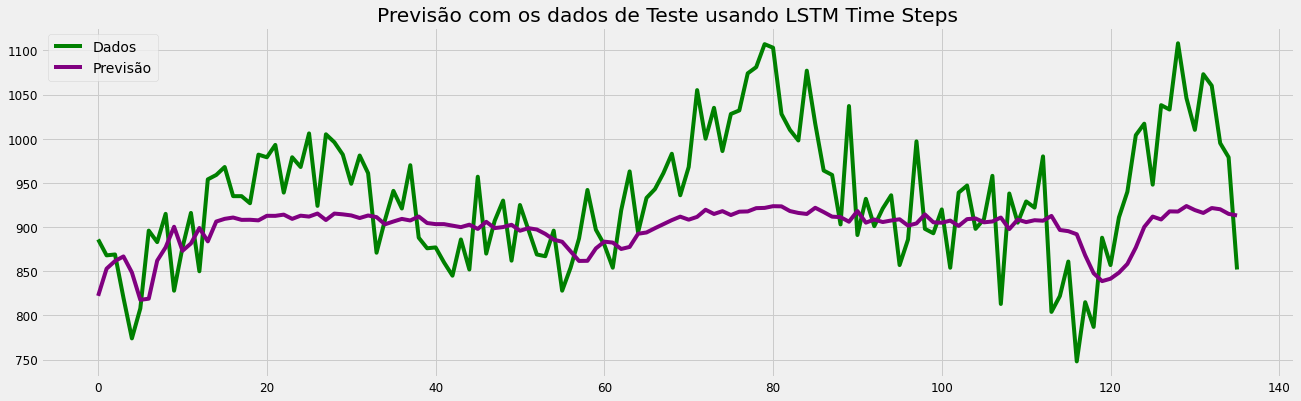

In [29]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Time Steps") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

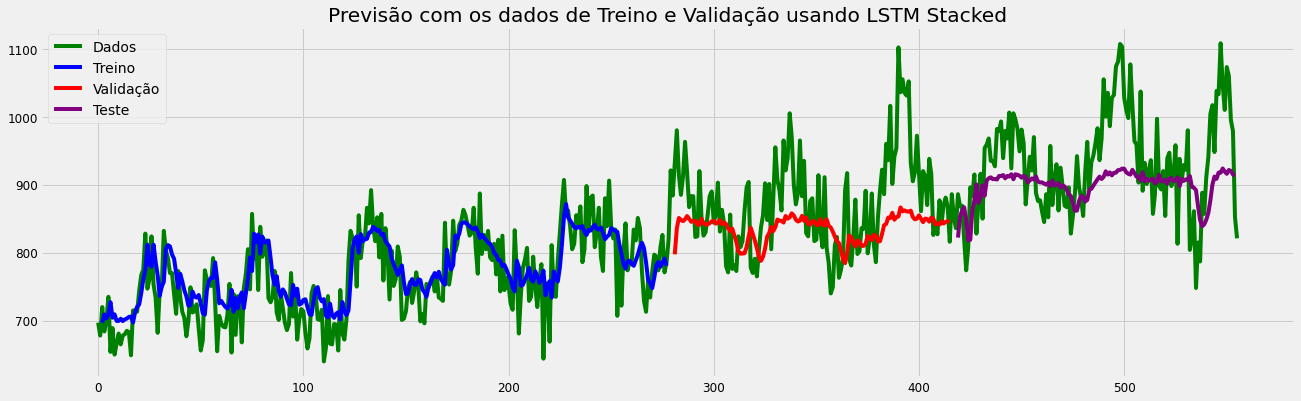

In [35]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(datasetfull)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict               

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
#testPredictPlot[len(testPredict)+(look_back*2)+1:len(datasetfull)-1, :] = testPredict
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*3)+2:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Stacked") 
plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim